In [ ]:
# Mounting my google drive in colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
#az veri setlerinde çoklama,veriyi döndürme vb. ImageDataGenerator
from keras.constraints import max_norm as maxnorm # güncel kullanım şekilleri
from keras.models import Sequential
# optimizer : ağdaki öğrenme öğreni hyperparametreleri
from keras.optimizers.legacy import SGD  # güncel kullanım şekilleri
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense
# keras modlü eski sürümleri destekler bu yüzden keras yerine tensorflow kullanarak güncel kütüphane erişimi sağlanır
from keras.utils import to_categorical # np_utils kullanımı artık yok onun yerine numpy ile kullanılıp to_categorical ile aynı kullanımı veriyor
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report
import os

In [ ]:
# Veri seti klasörünün yolu (Data klasörünüzün yolu)
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

data_dir = Path('/content/drive/MyDrive/AiResim/DataFlow/Data')
filepaths = list(data_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
train_df, test_df = train_test_split(images, train_size=0.8, shuffle=True, random_state=42)
train_df

,Filepath,Label
6686,/content/drive/MyDrive/AiResim/DataFlow/Data/D...,Dış Görünüm
333,/content/drive/MyDrive/AiResim/DataFlow/Data/O...,Odalar
4557,/content/drive/MyDrive/AiResim/DataFlow/Data/C...,Çocuk
1966,/content/drive/MyDrive/AiResim/DataFlow/Data/H...,Havuz-Plaj
4245,/content/drive/MyDrive/AiResim/DataFlow/Data/T...,Toplantı Salonu
...,...,...
5191,/content/drive/MyDrive/AiResim/DataFlow/Data/C...,Çocuk
5226,/content/drive/MyDrive/AiResim/DataFlow/Data/C...,Çocuk
5390,/content/drive/MyDrive/AiResim/DataFlow/Data/C...,Çocuk
860,/content/drive/MyDrive/AiResim/DataFlow/Data/O...,Odalar


In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
batch_size = 16
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        rescale=1./255,
        validation_split=0.1,
        rotation_range=20,
        zoom_range=0.2,
        fill_mode='nearest',
) # %70 eğitim datası içinden ön eğitim kontrölü içinde %20 yani 140 adet ön test (daha önceden gördüğü veri üzerinden test yapmak için) veri ayırıyoruz

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    labels='inferred',
    label_mode='int',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True, #karıştırma yapıyor
    seed=123,
    cros_to_aspect_ratio =False,
    follow_links=False,
    interpolation='bilinear',
    subset='training'
)
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    label_mode='int',
    labels='inferred',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    interpolation='bilinear',
    shuffle=True,
    seed=123,
    follow_links=False,
    cros_to_aspect_ratio =False,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    label_mode='int',
    labels='inferred',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    interpolation='bilinear',
    batch_size=batch_size,
    cros_to_aspect_ratio =False,
    follow_links=False,
    shuffle=False

)

Found 5453 validated image filenames belonging to 7 classes.
Found 605 validated image filenames belonging to 7 classes.
Found 1515 validated image filenames belonging to 7 classes.


In [ ]:
# CNN modelini oluşturun
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
#keras tuner hyperparametre ideal olanlarını belirlemek için kullanılır.
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history = model.fit(train_generator, epochs=30,validation_data=val_generator,callbacks=[callbacks])

Epoch 1/30
341/341 [==============================] - 2129s 6s/step - loss: 1.5503 - accuracy: 0.4086 - val_loss: 1.3706 - val_accuracy: 0.4860
Epoch 2/30
341/341 [==============================] - 95s 278ms/step - loss: 1.2868 - accuracy: 0.5230 - val_loss: 1.1608 - val_accuracy: 0.5537
Epoch 3/30
341/341 [==============================] - 95s 278ms/step - loss: 1.1721 - accuracy: 0.5698 - val_loss: 1.1033 - val_accuracy: 0.5736
Epoch 4/30
341/341 [==============================] - 94s 275ms/step - loss: 1.0522 - accuracy: 0.6184 - val_loss: 1.0481 - val_accuracy: 0.5950
Epoch 5/30
341/341 [==============================] - 95s 277ms/step - loss: 0.9910 - accuracy: 0.6418 - val_loss: 0.9924 - val_accuracy: 0.6298
Epoch 6/30
341/341 [==============================] - 95s 279ms/step - loss: 0.9123 - accuracy: 0.6754 - val_loss: 0.9117 - val_accuracy: 0.6595
Epoch 7/30
341/341 [==============================] - 96s 281ms/step - loss: 0.8652 - accuracy: 0.6846 - val_loss: 0.8795 - val_acc

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                        

In [ ]:
_,acc=model.evaluate(val_generator)
print(acc*100)

38/38 [==============================] - 9s 237ms/step - loss: 0.8365 - accuracy: 0.6992
69.91735696792603


In [ ]:
import warnings
warnings.filterwarnings("ignore")
model.save('Cnn_model.h5')

/content/Cnn_model.h5

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg


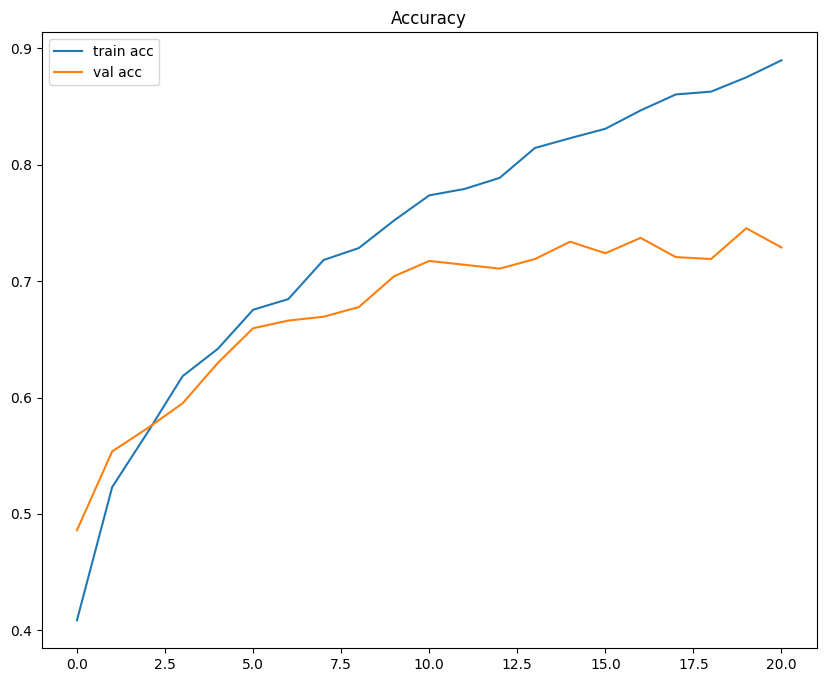

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'],label='train acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

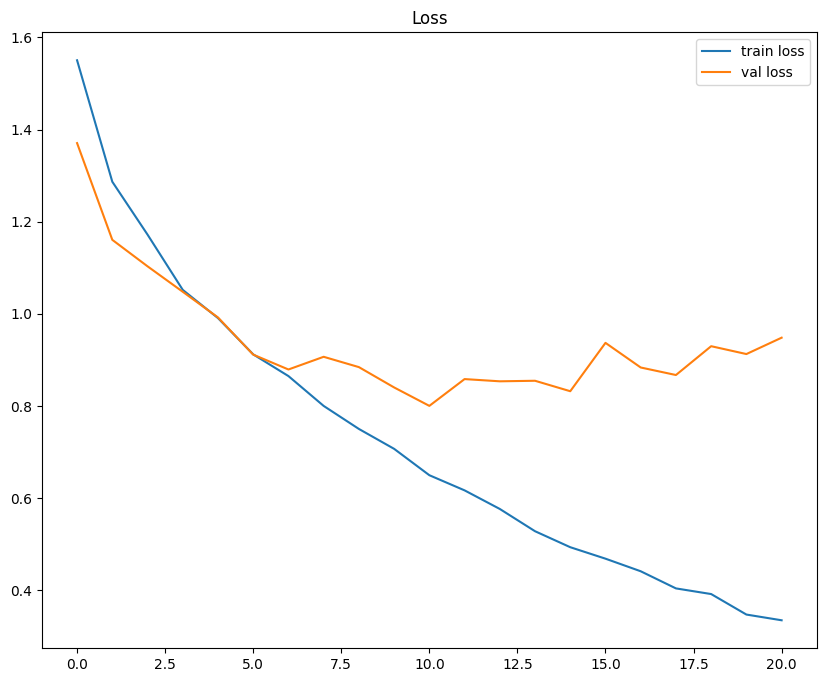

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
model.evaluate(val_generator,batch_size=32)

38/38 [==============================] - 9s 243ms/step - loss: 0.7899 - accuracy: 0.7140


[0.7899447083473206, 0.7140495777130127]

In [ ]:
# Modelinizi değerlendirme
loss, accuracy = model.evaluate(test_generator)
print("Test Doğruluğu:", accuracy)


95/95 [==============================] - 12s 122ms/step - loss: 210.9719 - accuracy: 0.5690
Test Doğruluğu: 0.568976879119873


In [ ]:
test= model.predict(test_generator)

95/95 [==============================] - 544s 6s/step


In [ ]:
test=np.argmax(test,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

matrix = confusion_matrix(test_generator.labels,test)
report = classification_report(test_generator.labels,test,target_names=test_generator.class_indices,zero_division=0)
#matrix
report

'                 precision    recall  f1-score   support\n\n       Aktivite       0.57      0.41      0.48       205\n         Çocuk       0.55      0.91      0.68       203\nDış Görünüm       0.57      0.52      0.55       223\n     Havuz-Plaj       0.94      0.82      0.88       231\n         Odalar       0.96      0.20      0.34       230\nToplantı Salonu       0.62      0.46      0.53       208\n    Yeme-İçme       0.34      0.67      0.45       215\n\n       accuracy                           0.57      1515\n      macro avg       0.65      0.57      0.56      1515\n   weighted avg       0.66      0.57      0.56      1515\n'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Başlangıç sayfası (konumun otel listesi)
start_url = "https://www.tripadvisor.com.tr/Hotels"

# Otel bağlantılarını toplamak için bir liste
otel_url_list = []

# İlk sayfa bağlantısını alın
response = requests.get(start_url)
print(response)
soup = BeautifulSoup(response.text, 'html.parser')

# Otel bağlantılarını çekmek için uygun HTML sınıfını veya etiketi bulun
otel_links = soup.select('a[href]')

for element in otel_links:
    print(element)
